In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
import itertools


### B-Optimization for Finding the whole function
This first codes shows the Bayesian optimization flows which allows to reconstruct an unknown function in a given interval. It samples random points inside the interval with known function values starting from two values and iteratively adding (x, f(x)) points until number_of_iterations is met. The function can have uniform white noise or not. At the end the first plot shows the real function and the second plot shows the sampled points and the expected function given by the mean of the Gaussian posteriors caluclated at the last step. The algorithm inverts the matrices with the Cholesky Decomposition. There are two functions:

- Kernel: given two vectors gives back the kernel calculated as $$ \sigma^2 e^{- \frac{1}{2l}(a - b)^2} $$, it accepts (N, 1) arrays in a way that is consistent with the dot operations in the following portion of the code. The values $\sigma$ and l are hyperparameters to set. 
- latent_function: its the real function we want to approximate, it accepts an array of values and gives back the value of the function calulcated at those values. It accepts the noise control which decides to add noise or not to the function.

<IPython.core.display.Javascript object>


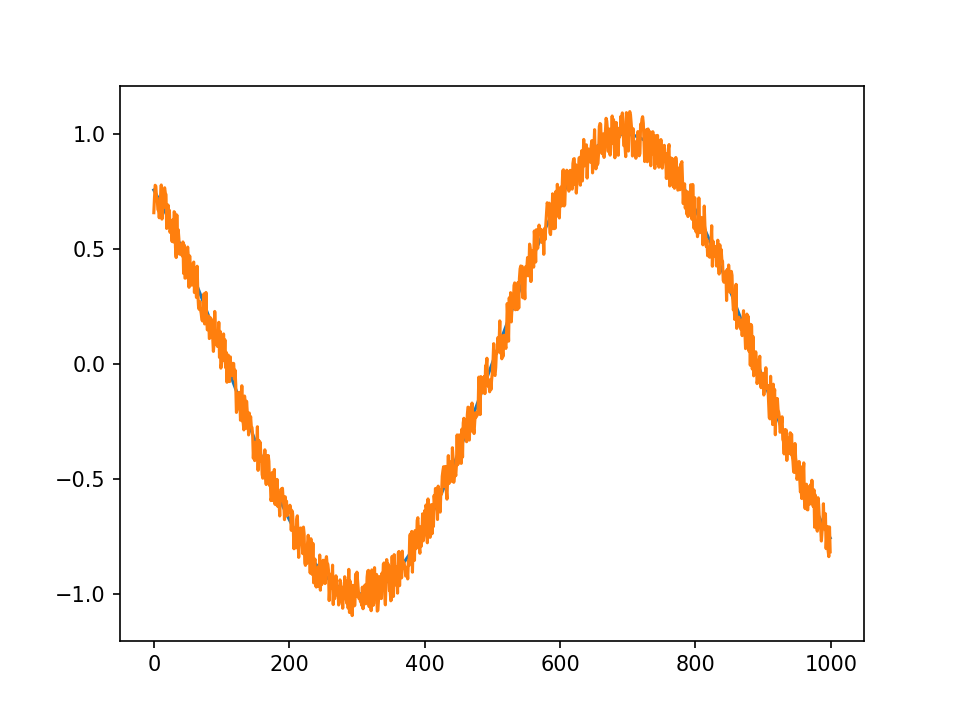

<IPython.core.display.Javascript object>


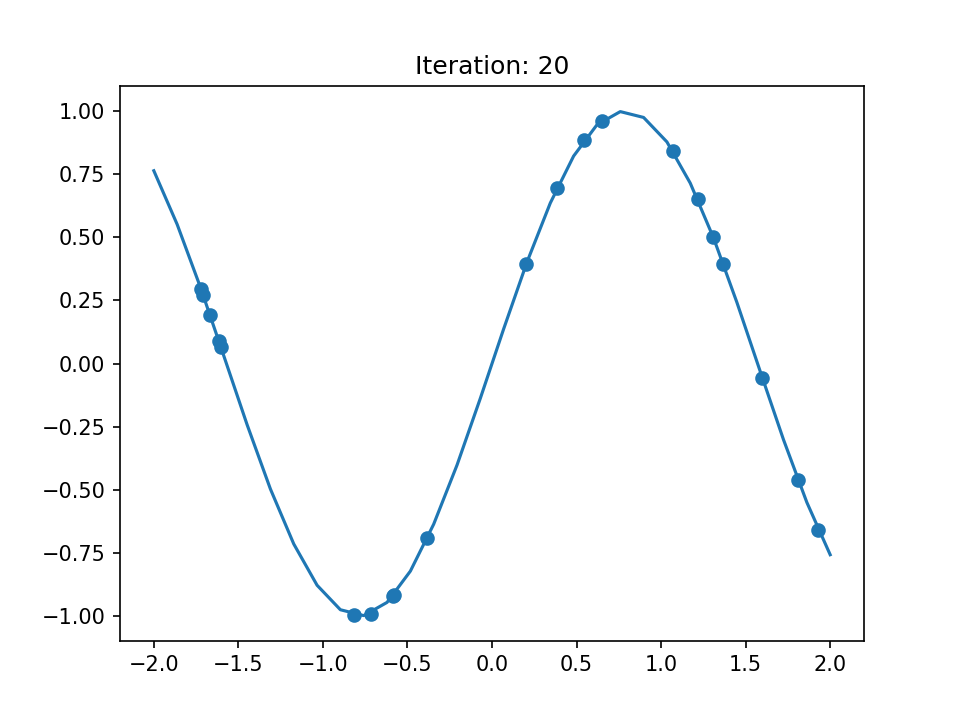

In [4]:
%matplotlib notebook


interval = [-2, 2]
number_of_iterations = 20
pause = 1
noise = False
noise_level = .1
l = 0.8
sigma = 3 

def kernel(a, b):
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-.5*sqdist/l)*sigma

def latent_function(X_train, noise):
    #return np.sin(2*X_train) - np.cos(X_train*3)**3*np.sin(X_train)**2  Possible non-easy function requires about 50 iterations
    if noise:
        return (np.sin(2*X_train).reshape(X_train.shape[0]) + np.random.uniform(-noise_level, noise_level, X_train.shape[0])).reshape(-1, 1)
    else:
        return np.sin(2*X_train)

fig = plt.figure()
plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), noise))
plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), not noise))


plt.show()
n_train = 1
n_test = 30

X_train = np.array(random.uniform(interval[0], interval[1])).reshape(-1, 1)
y_train = latent_function(X_train, noise)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(number_of_iterations):
    ax.clear()
    n_train += 1
    X_train = np.append(X_train, random.uniform(interval[0], interval[1])).reshape(-1, 1)
    y_train = latent_function(X_train, noise)
    X_test = np.linspace(interval[0], interval[1], n_test).reshape(-1, 1)
    K_ = kernel(X_train, X_train)
    
    if noise:
        L = np.linalg.cholesky(K_ + noise_level*np.eye(n_train) + 1e-6*np.eye(n_train))
    else:
        L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_train))
    #f_prior = np.dot(L, np.random.normal(size = (n, 10)))

    k_vector = np.array(kernel(X_train, X_test))

    y = np.linalg.solve(L, y_train)
    alpha_vector = np.linalg.solve(L.T, y)
    v_vector = np.linalg.solve(L, k_vector)

    f = y_train

    new_mean = np.dot(k_vector.T, alpha_vector).reshape(n_test)
    new_variance = np.diag(kernel(X_test, X_test) - np.dot(v_vector.T, v_vector))

    x = np.linspace(interval[0], interval[1], n_test)
    ax.set_title('Iteration: {}'.format(i+1))
    ax.plot(x, new_mean)
    ax.scatter(X_train, y_train)
    ax.fill_between(x, (new_mean -new_variance).reshape(-1), (new_mean + new_variance).reshape(-1))
    plt.pause(pause)  
    fig.canvas.draw()
      

In [8]:
def kernel(a, b):
    sqdist = 
    return np.exp(-.5*sqdist/l)*sigma

a = np.reshape([[1,2], [4,4]], (-1, 1))
kernel(a, a)

AxisError: axis 2 is out of bounds for array of dimension 2

### B-Optimization for finding minima
Same code as before but in this case we introduce an acquisition function that decides where to go and pick the next sample at each iteration (so they are not random in this case). At every step for every test point we calculate the cumulative distribution function with their current value using as mean the the lowest value of the mean and as variance their own variance. This gives the probability that the function at that point is larger then the current lowest value of the function. So we take the Q distribution which is the opposit: 1- cdf and obtain the probability that the function calculated at that test point is lower than the current lowest value of the mean. 

Now, our next point can be sampled with two methods:
- PROB OF IMPROVEMENT: We sample the next points where the qdf is maximum 
- EEXPECTED IMPROVEMENT: We sample the next point where the expectation of the acquisition function is maximum (suggested)

In [9]:
%matplotlib notebook

interval = [-2, 2]
number_of_iterations = 20
noise = False
noise_level = .1
acq_function = 'EI' #Either 'EI' or 'PI'

n_train = 2
n_test = 100
l = 0.8
sigma = 3 
pause = .2


def kernel(a, b):
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-.5*sqdist/l)*sigma

def latent_function(X_train, noise):
    #return np.sin(2*X_train) - np.cos(X_train*3)**3*np.sin(X_train)**2  Possible non-easy function requires about 50 iterations
    if noise:
        return (np.sin(2*X_train).reshape(X_train.shape[0]) + np.random.uniform(-noise_level, noise_level, X_train.shape[0])).reshape(-1, 1)
    else:
        return np.sin(2*X_train)

fig = plt.figure()
if noise:
    plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), noise))
    plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), not noise))
else:
    plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), noise))

plt.show()


X_train = np.array(np.random.uniform(interval[0], interval[1], 2)).reshape(-1, 1)
y_train = latent_function(X_train, noise)
#the first two values of x are picked randomly and then picked at the maximum of the qdf.
next_value = np.array(random.uniform(interval[0], interval[1]))

fig = plt.figure()
ax1, ax2 = fig.subplots(nrows = 2, ncols = 1)
plt.ion()

fig.show()
fig.canvas.draw()

while (np.abs(X_train[-1] - X_train[-2]) > 0.001) or (n_train<15):
    ax.clear()
    n_train += 1
    X_train = np.append(X_train, next_value).reshape(-1, 1)
    y_train = latent_function(X_train, noise)
    X_test = np.linspace(interval[0], interval[1], n_test).reshape(-1, 1)
    K_ = kernel(X_train, X_train)
    
    if noise:
        L = np.linalg.cholesky(K_ + noise_level*np.eye(n_train) + 1e-6*np.eye(n_train))
    else:
        L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_train))
    #f_prior = np.dot(L, np.random.normal(size = (n, 10)))

    k_vector = np.array(kernel(X_train, X_test))

    y = np.linalg.solve(L, y_train)
    alpha_vector = np.linalg.solve(L.T, y)
    v_vector = np.linalg.solve(L, k_vector)

    f = y_train

    new_mean = np.dot(k_vector.T, alpha_vector).reshape(n_test)
    new_variance = np.diag(kernel(X_test, X_test) - np.dot(v_vector.T, v_vector))
    mean_max = np.max(new_mean)
    mean_min = np.min(new_mean)
    
    #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
    cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_variance)
    pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_variance)
    
    #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
    qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_variance)
    
    if acq_function == 'PI':
        #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
        next_value = np.argmax(qdf)/n_test*(interval[1]-interval[0]) + interval[0]
    if acq_function == 'EI':
        alpha_function = (new_mean - mean_min - 0.001)*qdf + new_variance*pdf
        next_value = np.argmax(np.round(alpha_function, 3))/n_test*(interval[1]-interval[0]) + interval[0]
        
    ax1.clear()
    ax2.clear()
    x = np.linspace(interval[0], interval[1], n_test)
    ax1.set_title('Iteration: {}'.format(n_train))
    ax1.plot(x, new_mean)
    ax1.scatter(X_train, y_train)
    ax1.fill_between(x, (new_mean -new_variance).reshape(-1), (new_mean + new_variance).reshape(-1))
    if acq_function == 'PI':
        ax2.plot(x, mean_min - 1 + qdf, c = 'darkred', label = 'CDF')
    if acq_function == 'EI':
        ax2.plot(x, mean_min - 1 + np.round(alpha_function, 3), c = 'darkred', label = 'CDF')        
    plt.pause(pause)  
    fig.canvas.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### B-Optimization for Minima in 2D functions
Now we consider 2Dimensional functions. The BO is the same, we just use a different kernel: $$K (\mathbf{x}, \mathbf{x'}) =\sigma^2 e^{- \frac{1}{2l_1}(x_1 - x_1')^2 - \frac{1}{2l_2}(x_2 - x_2')^2} $$. Where now we have more hyperparameters but the same concept because the function $f(x_1, x_2)$ accepts two parameters and returns one. 


In [10]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

interval = [-2, 2]
number_of_iterations = 20
noise = False
noise_level = .1
acq_function = 'EI' #Either 'EI' or 'PI'

n_train = 2
n_test = 100
l = 0.8
sigma = 3 
pause = .5


def kernel(a, b):
    sqdist = np.sum(a**2, 1).reshape(-1, 2) + np.sum(b**2, 2) - 2*np.dot(a, b.T)
    return np.exp(-.5*sqdist/l)*sigma

def latent_function(X_train, noise):
    #return np.sin(2*X_train) - np.cos(X_train*3)**3*np.sin(X_train)**2  Possible non-easy function requires about 50 iterations
    if noise:
        return (np.sin(2*X_train[0] + np.cos(2*X_train[1])).reshape(X_train.shape[0], 2) + np.random.uniform(-noise_level, noise_level, X_train.shape[0])).reshape(-1, 1)
    else:
        return np.sin(2*X_train[:,0]) + np.cos(2*X_train[:,1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
if noise:
    plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), noise))
    plt.plot(latent_function(np.linspace(interval[0], interval[1], 1000), not noise))
else:
    X = np.linspace(interval[0], interval[1], 100)
    Y = X
    Z = latent_function(np.array(list((itertools.product(X, repeat = 2)))), noise).reshape((100,100))
    ax.plot_surface(X, Y, Z)

plt.show()

exit()
X_train = np.array(np.random.uniform(interval[0], interval[1], size = (2,2))).reshape(-1, 1)
print(X_train)
y_train = latent_function(X_train, noise)
#the first two values of x are picked randomly and then picked at the maximum of the qdf.
next_value = np.array(random.uniform(interval[0], interval[1]))

fig = plt.figure()
ax1, ax2 = fig.subplots(nrows = 2, ncols = 1)
plt.ion()

fig.show()
fig.canvas.draw()

while (np.abs(X_train[-1] - X_train[-2]) > 0.001) or (n_train<15):
    ax.clear()
    n_train += 1
    X_train = np.append(X_train, next_value).reshape(-1, 1)
    y_train = latent_function(X_train, noise)
    X_test = np.linspace(interval[0], interval[1], n_test).reshape(-1, 1)
    K_ = kernel(X_train, X_train)
    
    if noise:
        L = np.linalg.cholesky(K_ + noise_level*np.eye(n_train) + 1e-6*np.eye(n_train))
    else:
        L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_train))
    #f_prior = np.dot(L, np.random.normal(size = (n, 10)))

    k_vector = np.array(kernel(X_train, X_test))

    y = np.linalg.solve(L, y_train)
    alpha_vector = np.linalg.solve(L.T, y)
    v_vector = np.linalg.solve(L, k_vector)

    f = y_train

    new_mean = np.dot(k_vector.T, alpha_vector).reshape(n_test)
    new_variance = np.diag(kernel(X_test, X_test) - np.dot(v_vector.T, v_vector))
    mean_max = np.max(new_mean)
    mean_min = np.min(new_mean)
    
    #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
    cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_variance)
    pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_variance)
    
    #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
    qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_variance)
    
    if acq_function == 'PI':
        #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
        next_value = np.argmax(qdf)/n_test*(interval[1]-interval[0]) + interval[0]
    if acq_function == 'EI':
        alpha_function = (new_mean - mean_min - 0.001)*qdf + new_variance*pdf
        next_value = np.argmax(np.round(alpha_function, 3))/n_test*(interval[1]-interval[0]) + interval[0]
        
    ax1.clear()
    ax2.clear()
    x = np.linspace(interval[0], interval[1], n_test)
    ax1.set_title('Iteration: {}'.format(n_train))
    ax1.plot(x, new_mean)
    ax1.scatter(X_train, y_train)
    ax1.fill_between(x, (new_mean -new_variance).reshape(-1), (new_mean + new_variance).reshape(-1))
    if acq_function == 'PI':
        ax2.plot(x, mean_min - 1 + qdf, c = 'darkred', label = 'CDF')
    if acq_function == 'EI':
        ax2.plot(x, mean_min - 1 + np.round(alpha_function, 3), c = 'darkred', label = 'CDF')        
    plt.pause(pause)  
    fig.canvas.draw()

<IPython.core.display.Javascript object>

[[ 1.61206633]
 [ 1.20435206]
 [ 1.89155315]
 [-1.14906636]]


IndexError: index 1 is out of bounds for axis 1 with size 1

### GP with scikit Optimizer


In [25]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


interval = [-2, 2]
number_of_iterations = 10
pause = 1
noise = 0
noise_level = .1
l = 0.8
sigma = 3 

def latent_function(X_train, noise):
    #return np.sin(2*X_train) - np.cos(X_train*3)**3*np.sin(X_train)**2  Possible non-easy function requires about 50 iterations
    if noise:
        return (np.sin(2*X_train).reshape(X_train.shape[0]) + np.random.uniform(-noise_level, noise_level, X_train.shape[0])).reshape(-1, 1)
    else:
        return np.sin(2*X_train[:,0]) + np.cos(2*X_train[:,1])

n_train = 1
n_test = 30

X1 = np.random.uniform(interval[0], interval[1], size = 4)
X_train = np.array([[X1[0],X1[1]],[X1[2], X1[3]]])

y_train = latent_function(X_train, noise)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

pred_means = []
pred_sigma = []
for i in range(number_of_iterations):
    n_train += 1
    next_point = np.array([random.uniform(interval[0], interval[1]), random.uniform(interval[0], interval[1])])
    X_train = np.append(X_train, next_point, axis = 0)
    print(X_train.shape)
    print(X_train[0])
    y_train = latent_function(X_train, noise)
    X_test = np.linspace(interval[0], interval[1], n_test).reshape(-1, 1)
    
    gp.fit(X_train, y_train)
    y_test, sigma = gp.predict(X_test, return_std=True)
    y_test = np.reshape(y_test, n_test)
    sigma = np.array(sigma)
    pred_means.append(y_test)
    pred_sigma.append(sigma)

def plot_results(pred_means, pred_sigma, how_many):
    for i in range(how_many):
        x = np.linspace(interval[0], interval[1], n_test)
        ax.set_title('Iteration: {}'.format(i+1))
        ax.plot(x, y_test)
        ax.scatter(X_train, y_train)
        ax.fill_between(x, (y_test -sigma).reshape(-1), (y_test + sigma).reshape(-1))
        plt.pause(pause)  

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)